# install dependancies, takes around 45 seconds

Rendering Dependancies


In [1]:
!sudo apt-get update
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygame-2.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [3]:
# import some helper functions and tools
import gym
from gym import logger as gymlogger
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import time, math, random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

The Cart-Pole consists of a pole, which is connected to a horizontally moving cart. T solve the task, the pole has to be balanced by applying a force F to the cart, The system is nonlinear, since the rotation of the pole introduces trigonometric functions into the force balance equations.

 # State and Action
 All observations are assigned a uniformly random value in (-0.05, 0.05)

In [4]:
env = gym.make("CartPole-v0")
# The environment is old, there will be a warning. But there is no need to change the environment to a newer version.
env.reset()
# This will give you the initial states: [position, velocity, angle, angular velocity]

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([ 0.03889113, -0.00658859, -0.03885296, -0.02535179], dtype=float32)

In [5]:
print("upper bounds", env.observation_space.high)
print("lower bounds", env.observation_space.low)

upper bounds [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
lower bounds [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


The **states** of the Cart-Pole are the distance s of the cart, the velocity dot $\dot{s}$ of the cart, the angle of the pole $\theta$ and the angular velocity of the pole dot $\dot{\theta}$. In the environment, the observation of the environment will be $\text{obs}=[s,\dot{s},\theta,\dot{\theta}]$

In [6]:
env.action_space

Discrete(2)

The **action space** of the Cart-Pole environment is discrete, which includes 0 and 1. 0 means pushing the cart to the left, and 1 means pushing the cart to the right.

In [7]:
for i in range(10):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  print(reward)
  if done:
    break

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


**Reward:** Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475

For more details, please refer to the documentation of [OpenAI gym](https://www.gymlibrary.dev/environments/classic_control/cart_pole/). 

# Episode termination conditions

In [8]:
env.reset()
for i in range(100):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  if done:
    print(obs)
    if np.abs(obs[0]>2.4):
      print('Cart Position is greater than 2.4!')
    elif np.abs(obs[2]>0.2095):
      print('Pole angle is greater than 12 degree!')
    break

[-0.00566096 -0.5969058   0.2308374   1.4824127 ]
Pole angle is greater than 12 degree!


The episode ends if any one of the following occurs:

1. Termination: Pole Angle is greater than ±12°

2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

3. Truncation: Episode length is greater than 500.


# Helper functions for rendering

In [9]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [10]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = VideoRecorder(env, 'demo.mp4')
  return env

In [11]:
import gym
env = gym.make("CartPole-v0")
video = wrap_env(env)
obs = env.reset()
i = 0
while True:
    i+=1
    env.render()
    video.capture_frame()
    #your agent goes here
    action = env.action_space.sample() 
         
    obs, reward, done, info = env.step(action)   
    if done: 
      if np.abs(obs[0]>2.4):
        print('Cart Position is greater than 2.4!')
      elif np.abs(obs[2]>0.2095):
        print('Pole angle is greater than 12 degree!')
      break
video.close()            
env.close()
show_video()
#right click the video, you can download it!

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as 

Pole angle is greater than 12 degree!


# Questions begin here
Now we already have a basic understanding of the environment, let's have more fun!

In [72]:
# Define the Q agent
class Cart_Pole_Q_agent():
  def __init__(self, discretization_bin=(1,1,8,16),
                min_lr=0.1,
                lr=0.2,
                discount_factor = 0.99,
                exploration_decay_rate =0.99,
                exploration_rate =0.5,
                num_episodes=1000):
    # lr is short for learning rate, recall the update rule of Q learning, 
    #Q(s,a) += alpha*[R+gamma*max_aQ(s',a)-Q(s,a)]
    #lr = alpha
    #gamma = discount_factor
    self.min_lr = min_lr
    self.lr = lr
    self.discount_factor = discount_factor
    self.exploration_decay_rate = exploration_decay_rate
    self.exploration_rate = exploration_rate
    self.num_episodes = num_episodes
    self.env = gym.make('CartPole-v0')
    # Set the upper and lower bound
    # Discretize the state space
    self.discretization_bin = discretization_bin
    self.upperbound = [2.4,3.0,0.5,2.0]
    self.lowerbound = [-2.4,-3.0,-0.5,-2.0]
    self.action_space_len = self.env.action_space.n
    Q_table_size = self.discretization_bin+(self.action_space_len,)
    #Initilize the Q value for all state-action pairs as 0
    self.Q_tabular = np.zeros(Q_table_size)
  
  #Discretize the observations
  def discretize_obs(self, obs):
    discretized = list()
    for i in range(len(obs)):
      scaling = (obs[i] + abs(self.lowerbound[i])) / (self.upperbound[i] - self.lowerbound[i])
      new_obs = int(round((self.discretization_bin[i] - 1) * scaling))
      new_obs = min(self.discretization_bin[i] - 1, max(0, new_obs))
      discretized.append(new_obs)
    return tuple(discretized)
  
  # Choose the action
  def select_action(self, obs):
    #####explain why we need the first part to randomly pick actions
    if (np.random.random() < self.exploration_rate):
      return self.env.action_space.sample() 
    else:
      #choose the action
      ###### Your Code starts there

      maxQ = np.argmax(self.Q_tabular[obs])
      return maxQ;
      
      ###### Your Code ends there

  # Update Q table
  def update_the_Q_table(self, state, action, reward, new_state):
    ###### Your Code starts there
    alpha = self.lr;
    gamma = self.discount_factor;

    maxQprime = np.max(self.Q_tabular[new_state]);

    self.Q_tabular[state][action] = self.Q_tabular[state][action] + (alpha)*(reward + (gamma)*maxQprime - self.Q_tabular[state][action]);
    ###### Your Code ends there

  def get_exploration_rate(self):
    return self.exploration_rate*self.exploration_decay_rate

  def train(self):
    # you should collect all episodic rewards during training
    #
    reward_traj = []
    for e in range(self.num_episodes):
      ###### Your Code starts there
      self.exploration_rate = self.get_exploration_rate();
      obs = self.env.reset()
      state = self.discretize_obs(obs)
      current_reward = 0
      while True:
        
          action = self.select_action(state);
          obs, reward, done, info = self.env.step(action)

          new_state = self.discretize_obs(obs);
          self.update_the_Q_table(state,action,reward,new_state);
          state = new_state;
          current_reward = current_reward + 1;

          if done:
            break
          
      reward_traj.append(current_reward)
        ###### Your Code ends there

    print('Finished training!')
    return reward_traj

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Finished training!


Text(0, 0.5, 'Rewards')

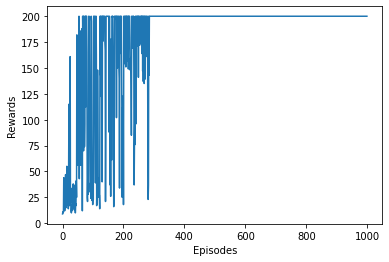

In [89]:
agent = Cart_Pole_Q_agent()
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
#plt.ylim([0,200]);


The figure above shows the correct output of rewards vs. episodes as we see the final policy reaching and converging to the max reward of 200.

Finished training!


Text(0, 0.5, 'Rewards')

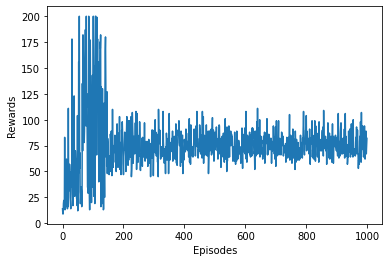

In [77]:
agent = Cart_Pole_Q_agent(lr = 0.5)
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
#plt.ylim([0,200]);

This figure above shows what happens to the system when we alter the learning rate (i.e. alpha). In this case, I changed the learning rate from it's initial value of 0.2 to 0.5, and we see a major decrease in the system's performance. 

Finished training!


Text(0, 0.5, 'Rewards')

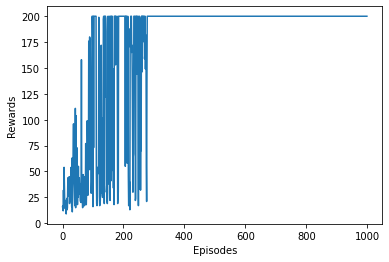

In [84]:
agent = Cart_Pole_Q_agent(exploration_rate = 0.99)
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')


In the figure above, I altered the exploration rate by increasing it from 0.5 to 0.99, and we see another precise system similar to figure 1. This shows that increasing the exploration rate allows for the policy to reach the max reward either at the same rate of more efficiently than before. 

Finished training!


Text(0, 0.5, 'Rewards')

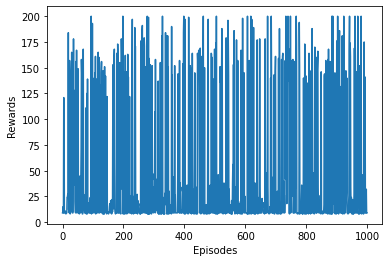

In [85]:
agent = Cart_Pole_Q_agent(exploration_rate = 0.1)
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')

In the figure above, I decreased the exploration rate from 0.5 to 0.1, and we see a drastic decrease in the system's performance. This shows that decreasing the exploration rate results in an unstable, far less efficient system. 

Finished training!


Text(0, 0.5, 'Rewards')

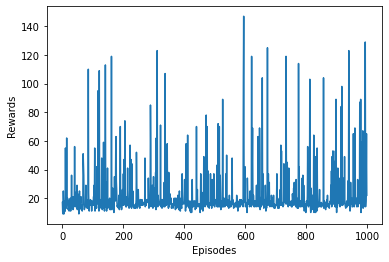

In [87]:
agent = Cart_Pole_Q_agent(discretization_bin = (1,1,16,32))
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')

In the figure above I increased the discretization bin by a factor of 2, which resulted in a decrease in the system's performance as the max reward of 200 is never consistently reached. This is due to the fact that increasing the discretization bin allows for more possible states that could not include the max reward, therefore making it less likely for the policy to achieve a consistent max reward (i.e. stability). 

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Finished training!


Text(0, 0.5, 'Rewards')

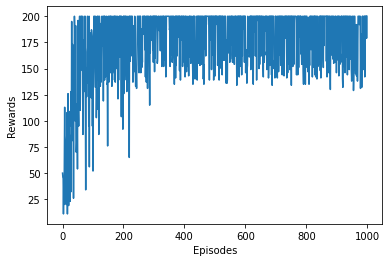

In [88]:
agent = Cart_Pole_Q_agent(discretization_bin = (1,1,2,4))
rwd_traj = agent.train()
plt.plot(range(len(rwd_traj)),rwd_traj)
plt.xlabel('Episodes')
plt.ylabel('Rewards')

In the figure above, I decreased the discretization bin by a factor of 2, which resulted in a much more stable system than when I increased the discretization bin by a factor of 2. This is because decreasing the discretization bin allows for less possible states to go through in order to reach the max reward. However, this is less efficient than the initial Q table since there are more instances in which the policy can reach a reward that is less than the max reward as seen in the figure above.  

In [90]:
# test the policy
import gym
env = gym.make("CartPole-v0")
video = wrap_env(env)
obs = env.reset()
###### Test the performance of your trianed agent 
###### Your Code starts there
timesteps = 0;
while True:
    timesteps +=1;
    env.render();
    video.capture_frame();

    state = agent.discretize_obs(obs);
    action = agent.select_action(state);
    obs, reward, done, info = env.step(action);

    if done:
      if(np.abs(obs[0])>2.4):
        print('Cart position is greater than 2.4')
      elif (np.abs(obs[2])>0.2095):
        print('Pole angle is greater than 12 degrees')
      break
print("timesteps : ", timesteps);

###### Your Code ends there
video.close()            
env.close()
show_video()
#right click the video, you can download it!

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as 

timesteps :  200


**Part 3 : Learning Rate and Exploration Rate** 

We want to use the exploration_rate rather than the optimal action (i.e. a = argmax_a Q(s,a)) since the exploration rate allows for more randomness in choosing the next state in the state space. When using the optimal action, choosing the next state isn't always obvious nor accurate so using exploration_rate allows for a higher probability of achieving the max reward.